In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/andrewmvd/car-plate-detection?resource=download")


Skipping, found downloaded files in "./car-plate-detection" (use force=True to force download)


In [5]:
!pip install ultralytics torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 56.3 MB/s eta 0:00:00


In [6]:
# Import necessary libraries
import os
import cv2
import shutil
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from glob import glob
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import torch

# Check CUDA availability
print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
torch.cuda.is_available() = True
torch.cuda.device_count() = 1


In [7]:
# Define Constants and Utility Functions

# Constants
dataset_path = '/content/car-plate-detection'

# Function to extract numbers from filename
def the_number_in_the_string(filename):
    """Extracts the first number from a string."""
    match = re.search(r'(\d+)', filename)
    return int(match.group(0)) if match else 0

# Parse XML files and extract labels
def parse_annotations(dataset_path):
    labels_dict = {'img_path': [], 'xmin': [], 'xmax': [], 'ymin': [], 'ymax': [], 'img_w': [], 'img_h': []}
    xml_files = glob(f'{dataset_path}/annotations/*.xml')

    for filename in sorted(xml_files, key=the_number_in_the_string):
        info = xet.parse(filename)
        root = info.getroot()
        member_object = root.find('object')
        labels_info = member_object.find('bndbox')

        img_name = root.find('filename').text
        img_path = os.path.join(dataset_path, 'images', img_name)

        # Append extracted information
        labels_dict['img_path'].append(img_path)
        labels_dict['xmin'].append(int(labels_info.find('xmin').text))
        labels_dict['xmax'].append(int(labels_info.find('xmax').text))
        labels_dict['ymin'].append(int(labels_info.find('ymin').text))
        labels_dict['ymax'].append(int(labels_info.find('ymax').text))

        height, width, _ = cv2.imread(img_path).shape
        labels_dict['img_w'].append(width)
        labels_dict['img_h'].append(height)

    return pd.DataFrame(labels_dict)


In [8]:
data = parse_annotations(dataset_path)
data.head()

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/content/car-plate-detection/images/Cars0.png,226,419,125,173,500,268
1,/content/car-plate-detection/images/Cars1.png,134,262,128,160,400,248
2,/content/car-plate-detection/images/Cars2.png,229,270,176,193,400,400
3,/content/car-plate-detection/images/Cars3.png,142,261,128,157,400,225
4,/content/car-plate-detection/images/Cars4.png,156,503,82,253,590,350


In [9]:
# Split dataset into train, validation, and test sets
def split_dataset(data):
    train, test = train_test_split(data, test_size=0.1, random_state=42)
    train, val = train_test_split(train, train_size=8/9, random_state=42)
    return train, val, test


In [10]:
train, val, test = split_dataset(data)
print(f'len(train) = {len(train)}, len(val) = {len(val)}, len(test) = {len(test)}')

len(train) = 345, len(val) = 44, len(test) = 44


In [11]:
# Create YOLO Format Dataset Structure

# Function to create YOLO dataset format
def make_split_folder_in_yolo_format(split_name, split_df):
    base_path = os.path.join('datasets', 'cars_license_plate', split_name)
    labels_path = os.path.join(base_path, 'labels')
    images_path = os.path.join(base_path, 'images')

    os.makedirs(labels_path, exist_ok=True)
    os.makedirs(images_path, exist_ok=True)

    for _, row in split_df.iterrows():
        img_name, _ = os.path.splitext(os.path.basename(row['img_path']))
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        shutil.copy(row['img_path'], os.path.join(images_path, img_name + os.path.splitext(row['img_path'])[1]))


In [12]:
# Remove existing datasets directory and create new one
if os.path.exists('datasets'):
  shutil.rmtree('datasets')

# Create YOLO format folders for train, validation, and test
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

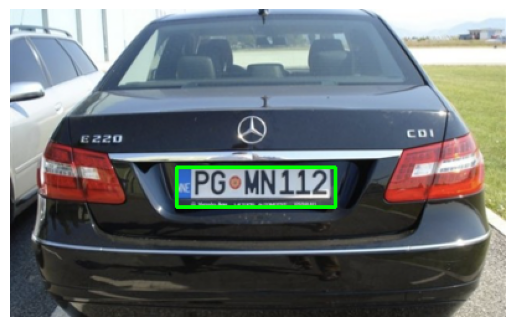

In [13]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory paths
image_dir = '/content/datasets/cars_license_plate/train/images'
label_dir = '/content/datasets/cars_license_plate/train/labels'

# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for the image and its corresponding label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file to get bounding box information
with open(label_path, 'r') as f:
    lines = f.readlines()

# Plot the bounding box on the image
for line in lines:
    # Parse the label file line to extract bounding box information
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image

In [14]:
# Define the content of the datasets.yaml file
datasets_yaml = '''
path: cars_license_plate

train: train/images
val: val/images
test: test/images

nc: 1  # Number of classes
names: ['license_plate']
'''

with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [15]:
# Initialize YOLO model and train it
model = YOLO('yolov8n.pt')
model.train(
    data='datasets.yaml', epochs=100, batch=16, imgsz=320, cache=True
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 145MB/s]


Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

100%|██████████| 755k/755k [00:00<00:00, 96.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 319MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/cars_license_plate/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 859.24it/s]


train: New cache created: /content/datasets/cars_license_plate/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:04<00:00, 74.61it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/datasets/cars_license_plate/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 372.09it/s]

val: New cache created: /content/datasets/cars_license_plate/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 84.24it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.646G      1.803      2.961      1.362         19        320: 100%|██████████| 22/22 [00:06<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         44         44    0.00382      0.909      0.395      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.614G       1.51      1.625      1.123         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.45it/s]


                   all         44         44      0.764     0.0747      0.383      0.194

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.623G      1.559      1.425      1.168         23        320: 100%|██████████| 22/22 [00:02<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.32it/s]

                   all         44         44      0.441     0.0909      0.212     0.0948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.617G      1.583      1.394      1.241         16        320: 100%|██████████| 22/22 [00:02<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.93it/s]

                   all         44         44      0.648      0.477      0.517      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.617G      1.524      1.283      1.182         20        320: 100%|██████████| 22/22 [00:05<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]

                   all         44         44      0.566      0.273      0.284       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.617G      1.521      1.232      1.192         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]

                   all         44         44      0.642      0.523      0.557      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.617G      1.453      1.169      1.172         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.55it/s]

                   all         44         44      0.768      0.753      0.792      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.617G      1.448      1.113      1.147         19        320: 100%|██████████| 22/22 [00:02<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]

                   all         44         44      0.788      0.795        0.8      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.617G      1.392      1.094      1.141         17        320: 100%|██████████| 22/22 [00:04<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         44         44       0.71      0.836       0.76      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.617G      1.382      1.038       1.14         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]

                   all         44         44      0.785      0.818       0.83      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.617G      1.332          1      1.112         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.03it/s]

                   all         44         44       0.79      0.682      0.761      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.617G      1.414     0.9884      1.137         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]

                   all         44         44      0.788      0.845      0.834      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.617G      1.442     0.9792      1.141         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.35it/s]

                   all         44         44      0.845      0.841      0.852      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.617G      1.374     0.9688      1.138         16        320: 100%|██████████| 22/22 [00:02<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]

                   all         44         44      0.769       0.83      0.842      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.614G      1.346     0.9359      1.105         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.70it/s]

                   all         44         44      0.845      0.869      0.897      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.617G      1.316     0.8798      1.113         13        320: 100%|██████████| 22/22 [00:02<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.87it/s]

                   all         44         44      0.811      0.881      0.865      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.614G      1.245     0.8698      1.079         16        320: 100%|██████████| 22/22 [00:03<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.50it/s]

                   all         44         44      0.774      0.795      0.812       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.617G      1.257     0.8297      1.073         21        320: 100%|██████████| 22/22 [00:03<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.61it/s]

                   all         44         44      0.829      0.773      0.815      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.617G      1.264     0.8035      1.084         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.48it/s]

                   all         44         44      0.799      0.795      0.855      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.617G      1.279     0.8359      1.088         24        320: 100%|██████████| 22/22 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]

                   all         44         44      0.832      0.841      0.865       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.617G      1.257     0.8213      1.091         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]

                   all         44         44      0.918       0.76      0.875      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.617G      1.251     0.8288      1.084         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.10it/s]

                   all         44         44      0.935      0.841      0.911      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.617G      1.298     0.8446       1.08         14        320: 100%|██████████| 22/22 [00:02<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.03it/s]

                   all         44         44      0.865      0.878      0.903      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.617G      1.191     0.7889      1.065         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]

                   all         44         44      0.906      0.874      0.913      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.614G      1.195      0.785      1.044         22        320: 100%|██████████| 22/22 [00:02<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]

                   all         44         44      0.925      0.837       0.87      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.617G      1.232     0.7656      1.081         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]

                   all         44         44      0.916      0.841      0.878      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.617G      1.169     0.7425      1.056         18        320: 100%|██████████| 22/22 [00:02<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.71it/s]

                   all         44         44      0.903      0.864      0.884      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.617G      1.135     0.7134      1.029         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.43it/s]

                   all         44         44      0.874      0.786      0.816      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.617G       1.12     0.7227      1.042         23        320: 100%|██████████| 22/22 [00:02<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]

                   all         44         44      0.812      0.886      0.845      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.617G      1.156     0.7168      1.044         17        320: 100%|██████████| 22/22 [00:03<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

                   all         44         44       0.93      0.909      0.928      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.617G       1.13     0.7083       1.04         16        320: 100%|██████████| 22/22 [00:03<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.51it/s]

                   all         44         44      0.879      0.822      0.885      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.617G      1.127     0.7025      1.043         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]

                   all         44         44      0.907      0.886      0.881      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.617G      1.212     0.7443      1.057         19        320: 100%|██████████| 22/22 [00:02<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.82it/s]


                   all         44         44      0.863      0.818      0.859      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.617G      1.077     0.6978      1.022         18        320: 100%|██████████| 22/22 [00:03<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.51it/s]

                   all         44         44          1      0.816      0.886      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.617G      1.071     0.6697       1.02         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.13it/s]

                   all         44         44      0.887      0.891      0.898       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.617G      1.089     0.6927      1.022         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]

                   all         44         44      0.941      0.841      0.936      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.617G      1.105     0.6921      1.021         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.57it/s]

                   all         44         44      0.922      0.864      0.921      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.617G      1.081     0.6631      1.011         19        320: 100%|██████████| 22/22 [00:02<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]

                   all         44         44      0.825      0.886       0.91      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.617G      1.039     0.6532      1.006         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

                   all         44         44      0.922      0.808      0.885      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.617G      1.024     0.6218     0.9937         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]

                   all         44         44      0.947      0.795       0.89      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.617G      1.057     0.6535      1.011         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.40it/s]

                   all         44         44      0.935      0.795      0.876      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.617G     0.9973     0.6178      1.002         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.96it/s]

                   all         44         44      0.896      0.773      0.854      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.617G      1.033     0.6258      1.007         14        320: 100%|██████████| 22/22 [00:03<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]

                   all         44         44      0.811      0.876      0.866      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.614G       1.06      0.636     0.9938         13        320: 100%|██████████| 22/22 [00:03<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]

                   all         44         44      0.915      0.795      0.873      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.617G      1.049     0.6281     0.9867         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.79it/s]


                   all         44         44       0.92      0.818      0.905      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.617G      1.064     0.6459      1.004         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.03it/s]

                   all         44         44      0.875      0.841      0.886      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.617G      1.021     0.6199     0.9884         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.29it/s]

                   all         44         44      0.934      0.841      0.906        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.617G     0.9682     0.5953     0.9676         13        320: 100%|██████████| 22/22 [00:04<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         44         44      0.934      0.818      0.887      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.617G     0.9593     0.5778     0.9698         12        320: 100%|██████████| 22/22 [00:02<00:00,  7.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.91it/s]

                   all         44         44      0.918      0.767      0.851      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.617G      1.022     0.6169     0.9824         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.11it/s]


                   all         44         44      0.838      0.864      0.905      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.617G      1.015     0.6198          1         18        320: 100%|██████████| 22/22 [00:02<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]

                   all         44         44      0.833      0.904      0.889      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.617G      1.018     0.5967     0.9942         17        320: 100%|██████████| 22/22 [00:03<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         44         44      0.898      0.797       0.87      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.617G     0.9662      0.581     0.9533         14        320: 100%|██████████| 22/22 [00:03<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.47it/s]

                   all         44         44      0.944      0.818      0.895       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.617G     0.9793     0.5762     0.9814         23        320: 100%|██████████| 22/22 [00:02<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.99it/s]


                   all         44         44      0.919      0.778      0.867       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.614G     0.9561     0.5811     0.9767         10        320: 100%|██████████| 22/22 [00:02<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.54it/s]

                   all         44         44      0.878      0.818      0.888      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.617G     0.9283     0.5774     0.9584         17        320: 100%|██████████| 22/22 [00:02<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.88it/s]

                   all         44         44      0.885      0.877       0.92      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.617G     0.9162     0.5656     0.9593         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.90it/s]

                   all         44         44      0.918      0.864      0.922      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.617G     0.9503     0.5873     0.9562         19        320: 100%|██████████| 22/22 [00:02<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.81it/s]

                   all         44         44      0.907      0.864      0.921      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.614G     0.9468     0.5595      0.965         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.69it/s]

                   all         44         44      0.941      0.864      0.927      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.617G     0.9399     0.5698     0.9835         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.95it/s]


                   all         44         44       0.89      0.918      0.925      0.549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.617G     0.9395     0.5637     0.9783         19        320: 100%|██████████| 22/22 [00:04<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.39it/s]

                   all         44         44      0.866      0.909      0.914      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.617G      0.893     0.5455     0.9602         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.49it/s]

                   all         44         44      0.849      0.864      0.914      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.614G     0.8745     0.5376     0.9582          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]

                   all         44         44      0.902      0.836      0.904      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.617G     0.8797     0.5497     0.9517         15        320: 100%|██████████| 22/22 [00:02<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.90it/s]


                   all         44         44      0.924      0.831      0.887      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.617G     0.9009     0.5498     0.9466         16        320: 100%|██████████| 22/22 [00:03<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

                   all         44         44      0.922       0.81        0.9        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.617G     0.8766     0.5357     0.9406         17        320: 100%|██████████| 22/22 [00:02<00:00,  7.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.87it/s]

                   all         44         44       0.91      0.818      0.914       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.614G     0.8935     0.5455     0.9439         11        320: 100%|██████████| 22/22 [00:02<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.19it/s]

                   all         44         44      0.905      0.818       0.91      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.617G     0.8603     0.5281     0.9275         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.42it/s]

                   all         44         44      0.872      0.841        0.9      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.617G     0.8224     0.5047     0.9452         17        320: 100%|██████████| 22/22 [00:03<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.16it/s]

                   all         44         44      0.943      0.795      0.903      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.617G     0.8364     0.4891     0.9448         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


                   all         44         44      0.945      0.784      0.901      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.617G     0.8623     0.5171     0.9316         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.84it/s]

                   all         44         44      0.945      0.785        0.9      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.617G     0.8577     0.5067     0.9462         15        320: 100%|██████████| 22/22 [00:02<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.39it/s]


                   all         44         44      0.912      0.818      0.889      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.614G      0.883     0.5093     0.9284         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.92it/s]

                   all         44         44      0.938      0.818      0.898      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.617G     0.8678     0.5126     0.9331         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         44         44      0.934      0.818      0.889      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.617G     0.8452      0.505      0.951         11        320: 100%|██████████| 22/22 [00:02<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.10it/s]

                   all         44         44      0.943      0.795      0.887      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.617G     0.8097     0.4982     0.9354         16        320: 100%|██████████| 22/22 [00:02<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.85it/s]


                   all         44         44      0.973      0.808      0.886      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.617G     0.8023     0.4744     0.9223         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]

                   all         44         44      0.957      0.795      0.891      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.617G     0.8351     0.4967     0.9347         14        320: 100%|██████████| 22/22 [00:04<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.68it/s]

                   all         44         44      0.895      0.773      0.887      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.617G     0.8134     0.4816     0.9304         20        320: 100%|██████████| 22/22 [00:02<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.16it/s]

                   all         44         44      0.907      0.773      0.884      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.617G     0.8226     0.5153     0.9344         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.09it/s]


                   all         44         44      0.919      0.771       0.89      0.533

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.617G     0.7901      0.487     0.9257         17        320: 100%|██████████| 22/22 [00:02<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.61it/s]

                   all         44         44      0.918      0.795      0.897      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.617G     0.8203     0.4867      0.924         20        320: 100%|██████████| 22/22 [00:03<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         44         44      0.894      0.818      0.898      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.617G     0.7871     0.4711      0.929         19        320: 100%|██████████| 22/22 [00:03<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.89it/s]


                   all         44         44      0.922      0.818      0.899      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.617G     0.7662     0.4766     0.9045         20        320: 100%|██████████| 22/22 [00:02<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.97it/s]

                   all         44         44      0.923      0.813      0.889      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.617G     0.8096     0.4769      0.925         16        320: 100%|██████████| 22/22 [00:04<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.56it/s]

                   all         44         44      0.921      0.795       0.89      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.617G     0.7749     0.4803     0.9227         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         44         44      0.938      0.795      0.899      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.617G     0.7482     0.4639     0.9021         22        320: 100%|██████████| 22/22 [00:02<00:00,  8.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.97it/s]

                   all         44         44      0.942      0.795      0.894      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.617G     0.7536     0.4592     0.9253         14        320: 100%|██████████| 22/22 [00:02<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.72it/s]

                   all         44         44      0.921      0.795      0.896      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.617G     0.7605     0.4535     0.9166         21        320: 100%|██████████| 22/22 [00:02<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]

                   all         44         44       0.96      0.795      0.901      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.617G     0.7443     0.4517     0.9202         15        320: 100%|██████████| 22/22 [00:04<00:00,  5.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.25it/s]

                   all         44         44      0.957      0.795      0.899      0.543


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.614G     0.9948     0.5383       1.01          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.40it/s]

                   all         44         44      0.941      0.795      0.887      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.614G     0.9933      0.528      1.032          9        320: 100%|██████████| 22/22 [00:02<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.78it/s]

                   all         44         44      0.956      0.795      0.895      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.614G     0.9373     0.5077      1.004          9        320: 100%|██████████| 22/22 [00:02<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.78it/s]


                   all         44         44       0.96      0.795      0.892      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.614G     0.9609     0.5038     0.9947          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.39it/s]

                   all         44         44      0.833      0.906      0.926       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.614G     0.9619     0.4957       1.01          9        320: 100%|██████████| 22/22 [00:03<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]

                   all         44         44      0.963      0.773      0.922      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.614G     0.9543     0.5113      1.005          9        320: 100%|██████████| 22/22 [00:02<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.17it/s]


                   all         44         44      0.962      0.773      0.921      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.614G     0.9292     0.4682     0.9943          9        320: 100%|██████████| 22/22 [00:02<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.86it/s]

                   all         44         44       0.96      0.773      0.904      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.614G     0.9168     0.4918     0.9803          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.22it/s]

                   all         44         44      0.959      0.773      0.906      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.614G     0.9087     0.4728     0.9914          9        320: 100%|██████████| 22/22 [00:04<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

                   all         44         44      0.959      0.773      0.908      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.614G     0.8804     0.4816     0.9711          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.81it/s]

                   all         44         44      0.958      0.773      0.891      0.568



100 epochs completed in 0.111 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


                   all         44         44      0.894      0.818      0.898      0.568
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train


In [16]:

# Save the trained model
model.save('/content/best_license_plate_model.pt')

Training results preview:
   epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1  11.5036         1.80302         2.96109         1.36216   
1      2  15.0045         1.51048         1.62507         1.12338   
2      3  18.3874         1.55940         1.42549         1.16760   
3      4  22.1347         1.58284         1.39380         1.24143   
4      5  28.3473         1.52441         1.28253         1.18193   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.00382            0.90909           0.39483   
1               0.76433            0.07470           0.38348   
2               0.44090            0.09091           0.21214   
3               0.64767            0.47727           0.51689   
4               0.56568            0.27273           0.28445   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.16810       1.52526       2.96878       1.06240  0.000420   
1              0.1

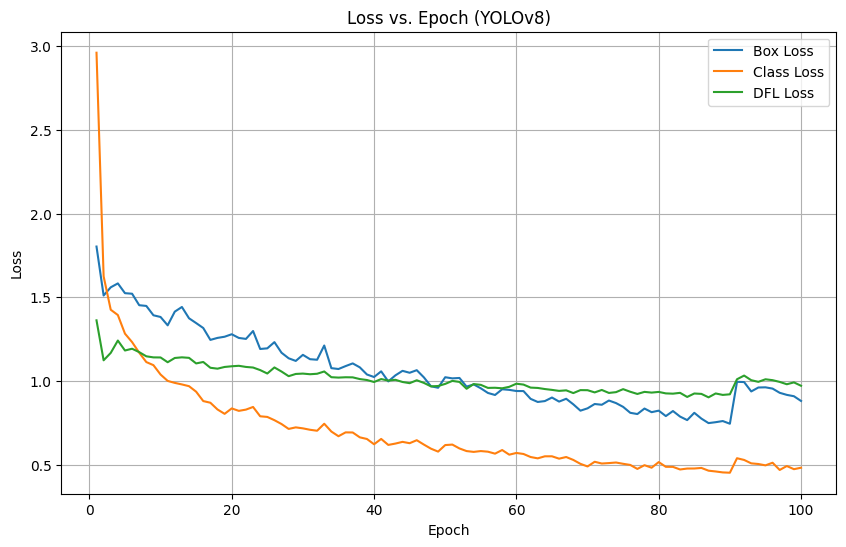

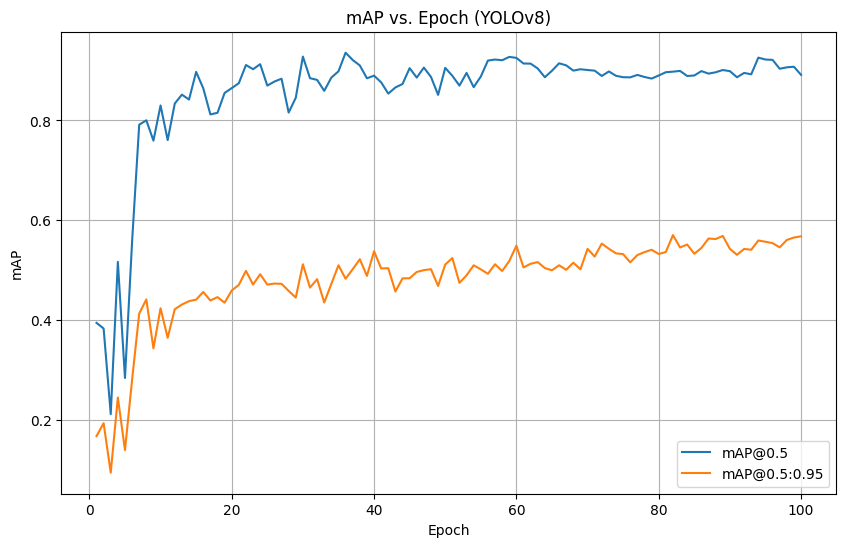

In [18]:
# Path to the directory containing YOLO training results
results_dir = os.path.join('/content','runs', 'detect')  # Replace 'detect' with your task type if different
latest_run_dir = sorted([os.path.join(results_dir, d) for d in os.listdir(results_dir)], key=os.path.getmtime)[-1]
results_file = os.path.join(latest_run_dir, 'results.csv')

# Check if the results file exists
if not os.path.exists(results_file):
    raise FileNotFoundError(f"Results file not found in the directory: {latest_run_dir}")

# Read the CSV file containing the training results
results_df = pd.read_csv(results_file)

# Display the first few rows of the results
print("Training results preview:")
print(results_df.head())

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Box Loss')  # Box loss (bounding boxes)
plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Class Loss')  # Classification loss
plt.plot(results_df['epoch'], results_df['train/dfl_loss'], label='DFL Loss')  # Distribution Focal Loss
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch (YOLOv8)')
plt.legend()
plt.grid()
plt.show()

# Plot mAP metrics
plt.figure(figsize=(10, 6))
plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP@0.5')  # mAP at IoU=0.5
plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')  # mAP across IoU thresholds
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP vs. Epoch (YOLOv8)')
plt.legend()
plt.grid()
plt.show()
